In [104]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from keras.utils import to_categorical
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.interpolate as interp
from tqdm.notebook import tqdm

In [72]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,2)

        self.layer2 = nn.Linear(2, 5)
        self.layer3 = nn.Linear(5, 3)
        self.first_layer_first_label_op = None

        
    def forward(self, x, interpolation_vals = None):
        x = self.layer1(x)

        if interpolation_vals is not None:
            x[0] = torch.FloatTensor(interpolation_vals)  ## list [1,2]
            # print("hardcoded valuees  to = ", x[0])
  
        self.first_layer_first_label_op = x[0].detach().numpy()

            

        x = F.relu(x)
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim = 1) # To check with the loss function
        return x, self.first_layer_first_label_op

In [73]:
features, labels = load_iris(return_X_y=True)
n_columns =2
features = features[:,: n_columns]

In [74]:

def create_interpolation(model, lower_x, upper_x, lower_y, upper_y, step_x, step_y, x_train , loss_fn = nn.CrossEntropyLoss() ):

    losses = []
    layer_1_outputs = []
    xs = np.arange(lower_x,upper_x+step_x, step_x)
    ys = np.arange(lower_y,upper_y+step_y, step_y)

    for x in tqdm(xs):
        for y in ys:
            y_pred,  intermediate_output_layer_1 = model(x_train, interpolation_vals = [x,y])

            layer_1_outputs.append(intermediate_output_layer_1)

            # print (intermediate_output_layer_1)
            loss = loss_fn(y_pred, y_train)
            losses.append(loss.item())

    ops =  np.array(layer_1_outputs)
    x_vals = ops[:,0].tolist()
    y_vals = ops[:,1].tolist()
    z_vals = losses

    return x_vals, y_vals, z_vals

In [141]:
def list_to_surface(x,y,z, num_steps):
    plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),num_steps),\
                           np.linspace(np.min(Y),np.max(Y),num_steps))
    plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')
    return plotx, ploty, plotz

In [239]:
model = Model(input_dim = 2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

x_train, y_train = Variable(torch.from_numpy(features)).float(), Variable(torch.from_numpy(labels)).long()

x_train.size()

torch.Size([150, 2])

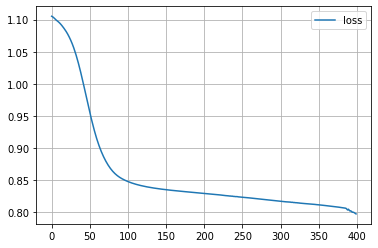

In [240]:
epochs = 400
losses = []
layer_1_outputs = []
for epoch in range(1, epochs+1):
    y_pred,  intermediate_output_layer_1 = model(x_train)

    layer_1_outputs.append(intermediate_output_layer_1)

    loss = loss_fn(y_pred, y_train)
    losses.append(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

plt.plot(losses, label = "loss")
plt.legend()
plt.grid()
plt.show()

In [248]:
x_vals, y_vals, z_vals = create_interpolation(model = model, 
                                              lower_x = -0,
                                              upper_x = 5,
                                              lower_y = -2,
                                              upper_y = 15,
                                              step_x = 0.2,
                                              step_y = 0.2,
                                              x_train = x_train,
                                            )
ops =  np.array(layer_1_outputs)
x_travel = ops[:,0].tolist()
y_travel = ops[:,1].tolist()

In [249]:
X = x_vals
Y = y_vals
Z = z_vals

plotx, ploty,plotz = list_to_surface(X,Y,Z, 10)

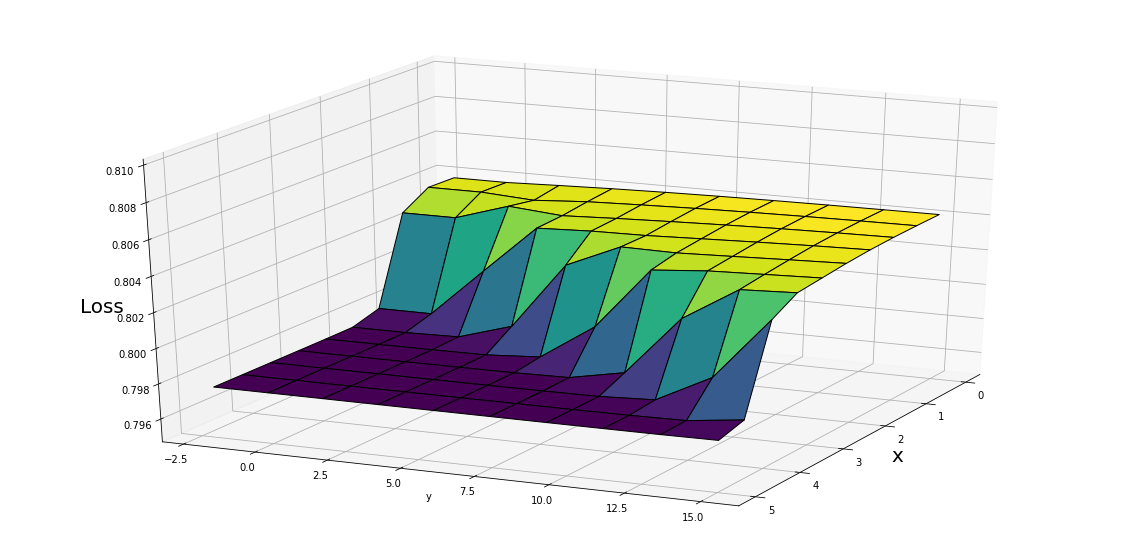

In [271]:


fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1,cmap = "viridis", edgecolor = "black")  # or 'hot'

ax.view_init(25, 25)

ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y')
ax.set_zlabel('Loss', fontsize = 20)

ax.set_zlim(0.795, 0.81)

fig.show()